In [1]:
"""
CNN Execrise: facemask detection with data augumentation
Display the accuracy of the model on the test data
show the gg plot
May 25, 2022
@author: Gaddisa Olani
"""


In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
#setting directory path for dataset
Dataset = "data"
Data_dir = os.listdir(Dataset)
print(Data_dir)

['without_mask', 'with_mask']


In [3]:
#data preprocessing
img_rows,img_cols = 112,112

images = []
labels = [] 

for category in Data_dir:
  folder_path = os.path.join(Dataset,category)
  for img in os.listdir(folder_path):
    img_path = os.path.join(folder_path,img)
    img = cv2.imread(img_path)

    try:
      #converting image into gray scale
      grayscale_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

      #resizing gray scaled image into size 56x56
      resized_img =  cv2.resize(grayscale_img,(img_rows,img_cols))
      images.append(resized_img)
      labels.append(category)
    #Exception Handling
    except Exception as e:
      print("Exception Details : " + e)
images = np.array(images) /255.0
images = np.reshape(images,(images.shape[0],img_rows,img_cols,1))

#performing one hot encoding
lb = LabelBinarizer() 
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels = np.array(labels)

(train_X,test_X,train_y,test_y) = train_test_split(images,labels,test_size = 0.25,random_state= 0)

In [4]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [5]:
#Building CNN model via Sequential API
num_classes = 2
batch_size = 32
model = Sequential()

#First Layer
model.add(Conv2D(64,(3,3), input_shape = (img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#Flatten and Dropout Layer
model.add(Flatten())
model.add(Dropout(0.5))

#Softmax Classifier
model.add(Dense(64,activation = "relu"))
model.add(Dense(num_classes,activation= "softmax"))

print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [11]:
"""
**Train the Model**"""
epochs = 50
batch_size=64
model.compile(loss= 'categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#fitted_model = model.fit(train_X,train_y,epochs = epochs,validation_split=0.25)
fitted_model = model.fit(
	aug.flow(train_X, train_y, batch_size=batch_size),
	steps_per_epoch=len(train_X) // batch_size,
	validation_data=(test_X, test_y),
	validation_steps=len(test_X) // batch_size,
	epochs=epochs)

Epoch 1/50
16/16 [==============================] - 12s 686ms/step - loss: 0.5898 - accuracy: 0.6887 - val_loss: 0.3384 - val_accuracy: 0.8876
Epoch 2/50
16/16 [==============================] - 10s 694ms/step - loss: 0.5096 - accuracy: 0.7714 - val_loss: 0.4530 - val_accuracy: 0.7791
Epoch 3/50
16/16 [==============================] - 11s 709ms/step - loss: 0.5259 - accuracy: 0.7558 - val_loss: 0.2723 - val_accuracy: 0.9186
Epoch 4/50
16/16 [==============================] - 11s 680ms/step - loss: 0.4756 - accuracy: 0.7977 - val_loss: 0.2598 - val_accuracy: 0.9264
Epoch 5/50
16/16 [==============================] - 11s 676ms/step - loss: 0.4239 - accuracy: 0.8054 - val_loss: 0.2587 - val_accuracy: 0.8915
Epoch 6/50
16/16 [==============================] - 11s 681ms/step - loss: 0.4333 - accuracy: 0.8066 - val_loss: 0.1917 - val_accuracy: 0.9341
Epoch 7/50
16/16 [==============================] - 11s 681ms/step - loss: 0.3654 - accuracy: 0.8597 - val_loss: 0.1884 - val_accuracy: 0.9264

In [19]:
# make predictions on the testing set

print("[INFO] evaluating your model on test dataset...")
predIdxs = model.predict(test_X, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print("Classification report of your model...")

print(classification_report(test_y.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating your model on test dataset...
Classification report of your model...
              precision    recall  f1-score   support

   with_mask       0.98      0.97      0.98       169
without_mask       0.97      0.98      0.98       175

    accuracy                           0.98       344
   macro avg       0.98      0.98      0.98       344
weighted avg       0.98      0.98      0.98       344



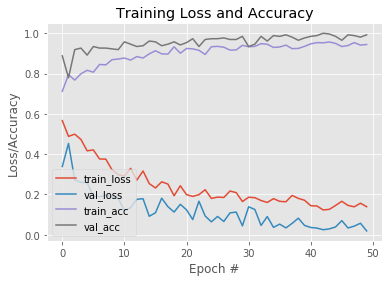

In [17]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), fitted_model.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), fitted_model.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), fitted_model.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), fitted_model.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
